In [84]:
import torch
from torch import nn
import torchvision
import requests
import zipfile
from pathlib import Path
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchinfo
import os
import random
from PIL import Image
from typing import Tuple, Dict, List
import tqdm

In [85]:
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
    print(f'{image_path} already exists')
else:
    image_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print('Downloading data...')
        f.write(request.content)

    with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_file:
        zip_file.extractall(image_path)

data\pizza_steak_sushi already exists


# 1. Data Preparation
Data preparation is paramount. Before building a model, become one with the data. **Ask yourself: What am I trying to do here?**

The goal is to **take data storage structure and convert it into a dataset usable for our model-building purposes**

In [86]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [87]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data\pizza_steak_sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\test
There are 0 directories and 25 images in data\pizza_steak_sushi\test\pizza
There are 0 directories and 19 images in data\pizza_steak_sushi\test\steak
There are 0 directories and 31 images in data\pizza_steak_sushi\test\sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\train
There are 0 directories and 78 images in data\pizza_steak_sushi\train\pizza
There are 0 directories and 75 images in data\pizza_steak_sushi\train\steak
There are 0 directories and 72 images in data\pizza_steak_sushi\train\sushi


In [88]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

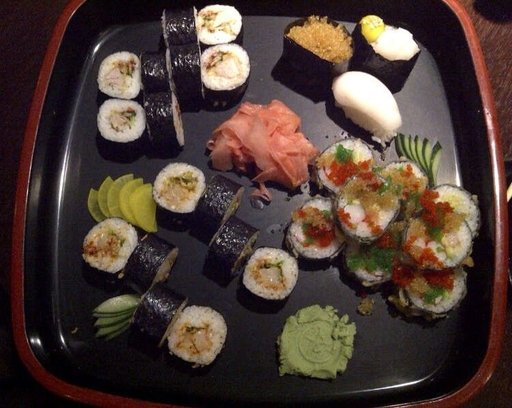

In [89]:
random.seed(178)
image_path_list = list(image_path.glob('*/*/*.jpg'))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
img

# 2. Data Transformation
1. Turn data into tensors, i.e., numerical representation
2. Turn the numerical representation into a ```torch.utils.data.Dataset``` and subsequently, into a ```torch.utils.data.DataLoader```

In [90]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(64, 64)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor()
])

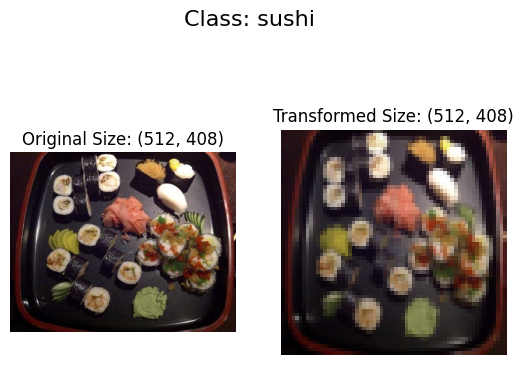

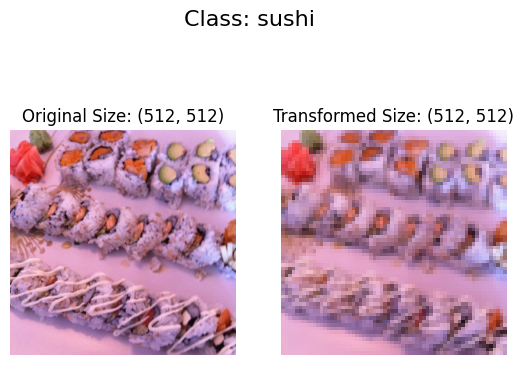

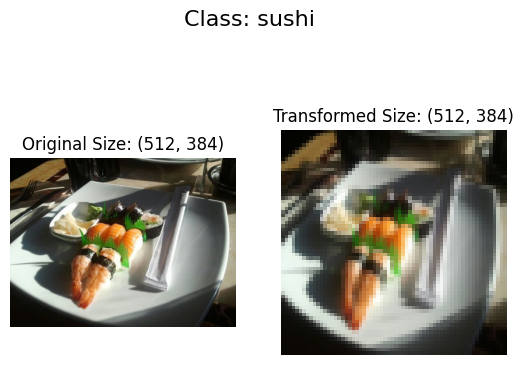

In [91]:
def plot_transformed_images(image_paths, transform, n=3, seed=178):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f'Original Size: {f.size}')
            ax[0].axis('off')


            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed Size: {f.size}')
            ax[1].axis('off')

            fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)


plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

# 3. Loading Image Data Using ```ImageFolder```

In [92]:
training_data = torchvision.datasets.ImageFolder(root=train_dir,
                                                 transform=data_transform,
                                                 target_transform=None)

test_data = torchvision.datasets.ImageFolder(root=test_dir,
                                             transform=data_transform)

print(f'Training data: {training_data},'
      f'Test data: {test_data}')

Training data: Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           ),Test data: Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [93]:
class_names = training_data.classes
class_names

['pizza', 'steak', 'sushi']

In [94]:
class_dict = training_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [95]:
len(training_data), len(test_data)

(225, 75)

In [96]:
os.cpu_count()

8

In [97]:
training_dataloader = DataLoader(dataset=training_data,
                                 batch_size=1,
                                 num_workers=1,
                                 shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=True)

training_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x140b2136950>,
 <torch.utils.data.dataloader.DataLoader at 0x140b0f58c10>)

# 4. Loading Image Data with Custom ```Dataset```

# 5. Data Augmentation
**Data Augmentation** is the process of altering the data in such a way that the **diversity** of the data is increased. This culminates in a model which is more capable of *generalization*.

In [98]:
training_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.TrivialAugmentWide(num_magnitude_bins=31),
    torchvision.transforms.ToTensor(),
])

test_transformations = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
])

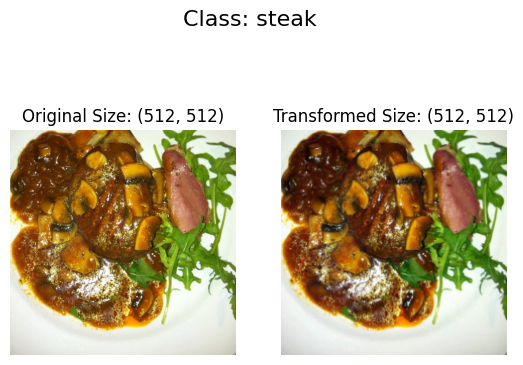

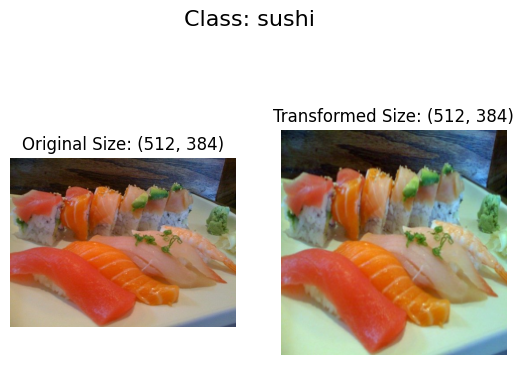

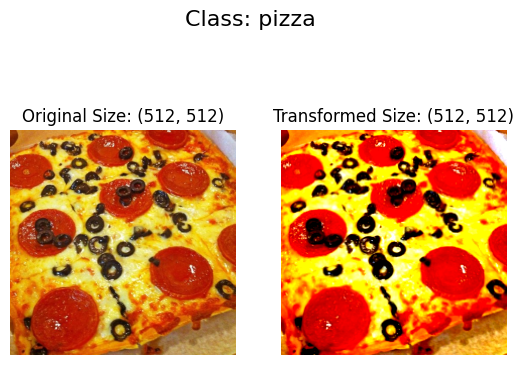

In [99]:
plot_transformed_images(image_path_list, training_transforms, seed=None)

# 6. Model 0: TinVGG without Data Augmentation

In [100]:
simple_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
])

In [101]:
training_data_simple = torchvision.datasets.ImageFolder(root=train_dir, transform=simple_transforms)

test_data_simple = torchvision.datasets.ImageFolder(root=test_dir, transform=simple_transforms)

In [102]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

training_dataloader_simple = DataLoader(training_data_simple,
                                        BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=NUM_WORKERS)

training_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x140afc9c3d0>,
 <torch.utils.data.dataloader.DataLoader at 0x140b0effb90>)

In [103]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return self.classifier(x)

In [104]:
torch.manual_seed(178)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(training_data.classes))

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [105]:
torchinfo.summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [106]:
def training_phase(model: torch.nn.Module,
                   dataloader: torch.utils.data.DataLoader,
                   loss_func: torch.nn.Module,
                   optimizer: torch.optim.Optimizer):
    model.train()
    training_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        y_pred = model(X)

        loss = loss_func(y_pred, y)
        training_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)

    training_loss /= len(dataloader)

    return training_loss

In [107]:
def test_phase(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_func: torch.nn.Module):

    model.eval()
    test_loss = 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            test_pred_logits = model(X)
            loss = loss_func(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_label = test_pred_logits.argmax(dim=1)


    test_loss /= len(dataloader)

    return test_loss

In [108]:
def train(model: torch.nn.Module,
          training_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_func: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int=10):
    results = {
        'training_loss': [],
        'test_loss': [],
    }

    for epoch in tqdm(range(epochs)):
        training_loss = training_phase(model,
                                       dataloader=training_dataloader,
                                       loss_func=loss_func,
                                       optimizer=optimizer)
        test_loss = test_phase(model,
                               dataloader=test_dataloader,
                               loss_func=loss_func)

        print(f'Epoch: {epoch},'
              f'training_loss: {training_loss:.4f},'
              f'test_loss: {test_loss:.4f}')

        results['training_loss'].append(training_loss)
        results['test_loss'].append(test_loss)

    return results

In [109]:
torch.manual_seed(178)
NUM_EPOCHS=10

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(training_data.classes))

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.1)

model_0_results = train(model_0,
                        training_dataloader_simple,
                        test_dataloader_simple,
                        loss_func,
                        optimizer,
                        epochs=NUM_EPOCHS)

model_0_results

TypeError: 'module' object is not callable